In [ ]:
pip install pretty_midi


**Justification:** MIDI handling.

In [ ]:
import os
import pretty_midi
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import GPT2LMHeadModel, GPT2Tokenizer, TrainingArguments, DataCollatorForLanguageModeling, Trainer, default_data_collator
import music21
import subprocess
import warnings
import matplotlib.pyplot as plt

# Suppress specific warnings from pretty_midi
warnings.filterwarnings("ignore", category=UserWarning, module='pretty_midi')

# Suppress all warnings from music21
warnings.filterwarnings("ignore", module='music21')

class MIDIDataset(Dataset):
    def __init__(self, root_dirs, tokenizer, max_length=512):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.files = self._gather_midi_files(root_dirs)
        self.files = self._filter_valid_files(self.files)
        self.total_duration = self.calculate_total_duration()

    def _gather_midi_files(self, root_dirs):
        files = []
        for root_dir in root_dirs:
            for subdir, _, filenames in os.walk(root_dir):
                for filename in filenames:
                    if filename.endswith('.midi') or filename.endswith('.mid'):
                        files.append(os.path.join(subdir, filename))
        return files

    def _filter_valid_files(self, files):
        valid_files = []
        for file in files:
            try:
                midi_data = pretty_midi.PrettyMIDI(file)
                if any(instrument.notes for instrument in midi_data.instruments):
                    valid_files.append(file)
                else:
                    print(f"No valid notes found in {file}. Skipping...")
            except Exception as e:
                print(f"Error reading {file}: {e}. Skipping...")
        return valid_files

    def calculate_total_duration(self):
        total_duration = 0.0
        for file in self.files:
            try:
                score = music21.converter.parse(file)
                total_duration += score.duration.quarterLength
            except Exception as e:
                print(f"Error processing {file}: {e}. Skipping...")
        return total_duration

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        midi_file = self.files[idx]
        midi_data = pretty_midi.PrettyMIDI(midi_file)

        notes = []
        durations = []
        for instrument in midi_data.instruments:
            for note in instrument.notes:
                notes.append(note.pitch)
                durations.append(note.end - note.start)

        tokens = self.tokenizer(
            " ".join(map(str, notes)),
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': tokens.input_ids.squeeze(0),
            'attention_mask': tokens.attention_mask.squeeze(0)
        }

# Paths to your datasets
indian_dataset_path = '/content/drive/MyDrive/Dataset Music/Msc/Indian'
western_dataset_path = '/content/drive/MyDrive/Dataset Music/Msc/Western'

# Initialize tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

# Load and filter the dataset
combined_dataset = MIDIDataset(root_dirs=[indian_dataset_path, western_dataset_path], tokenizer=tokenizer)
print(f"Total duration of the dataset: {combined_dataset.total_duration:.2f} quarter lengths")

# Split into training and validation sets
train_size = int(0.8 * len(combined_dataset))
val_size = len(combined_dataset) - train_size
train_dataset, val_dataset = random_split(combined_dataset, [train_size, val_size])

if len(combined_dataset) == 0:
    raise ValueError("The combined dataset is empty. Please check if the directories contain valid MIDI files.")

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=default_data_collator)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=default_data_collator)

print(f"Number of samples in the training set: {len(train_dataset)}")
print(f"Number of samples in the validation set: {len(val_dataset)}")

/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Error reading /content/drive/MyDrive/Dataset Music/Msc/Western/Classic/Bomfunk_MCs_-_Uprocking_Beats.mid: MThd not found. Probably not a MIDI file. Skipping...
Error reading /content/drive/MyDrive/Dataset Music/Msc/Western/Classic/Elmer_Bernstein_-_.mid: . Skipping...
Error reading /content/drive/MyDrive/Dataset Music/Msc/Western/Classic/Mahler_Gustav_-_Symphony_#2_(Tenor).mid: data byte must be in range 0..127. Skipping...
Error reading /content/drive/MyDrive/Dataset Music/Msc/Western/Classic/Mahler_Gustav_-_Symphony_#2_(Tenor2).mid: data byte must be in range 0..127. Skipping...
Error reading /content/drive/MyDrive/Dataset Music/Msc/Western/Classic/Unknown_-_pokemon.mid: list index out of range. Skipping...
No valid notes found in /content/drive/MyDrive/Dataset Music/Msc/Western/Classic/Kona_-_Drumloop.mid. Skipping...
No valid notes found in /content/drive/MyDrive/Dataset Music/Msc/Western/Classic/un_debut_au_piano_-_my_first_composition.mid. Skipping...
Error reading /content/drive

**Justification:** The code prepares a MIDI dataset for training a music generation model. It collects, filters, and tokenizes MIDI files, calculates the dataset's total duration, and splits the data into training and validation sets. It ensures data quality and compatibility with GPT-2, streamlining the process for model training and evaluation.

In [ ]:
# Load pre-trained GPT-2 model
model = GPT2LMHeadModel.from_pretrained('gpt2')
model.config.pad_token_id = model.config.eos_token_id

# Training arguments
train_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy="epoch",  # Changed to eval_strategy as evaluation_strategy is deprecated
    save_strategy="epoch",
    report_to="none"  # Disable automatic logging
)

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

trainer = Trainer(
    model=model,
    args=train_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
)

# Train and evaluate the model
train_results = trainer.train()
eval_results = trainer.evaluate()

# Calculate perplexity from the loss
perplexity = torch.exp(torch.tensor(eval_results['eval_loss']))
print(f"Validation Perplexity: {perplexity.item()}")

# Save the trained model and tokenizer
model_save_path = './fine_tuned_gpt2_music_model'
tokenizer_save_path = './fine_tuned_gpt2_music_tokenizer'

model.save_pretrained(model_save_path)
tokenizer.save_pretrained(tokenizer_save_path)
print(f"Model saved to {model_save_path}")
print(f"Tokenizer saved to {tokenizer_save_path}")


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss
1,3.068600,3.019146
2,2.659800,2.843429
3,3.101600,2.836447


/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Validation Perplexity: 17.055065155029297
Model saved to ./fine_tuned_gpt2_music_model
Tokenizer saved to ./fine_tuned_gpt2_music_tokenizer


**Justification:** The code fine-tunes a GPT-2 model for music generation using a MIDI dataset. It configures training parameters, evaluates model performance, calculates perplexity, and saves the fine-tuned model and tokenizer for future use. This process customizes GPT-2 for generating music sequences.

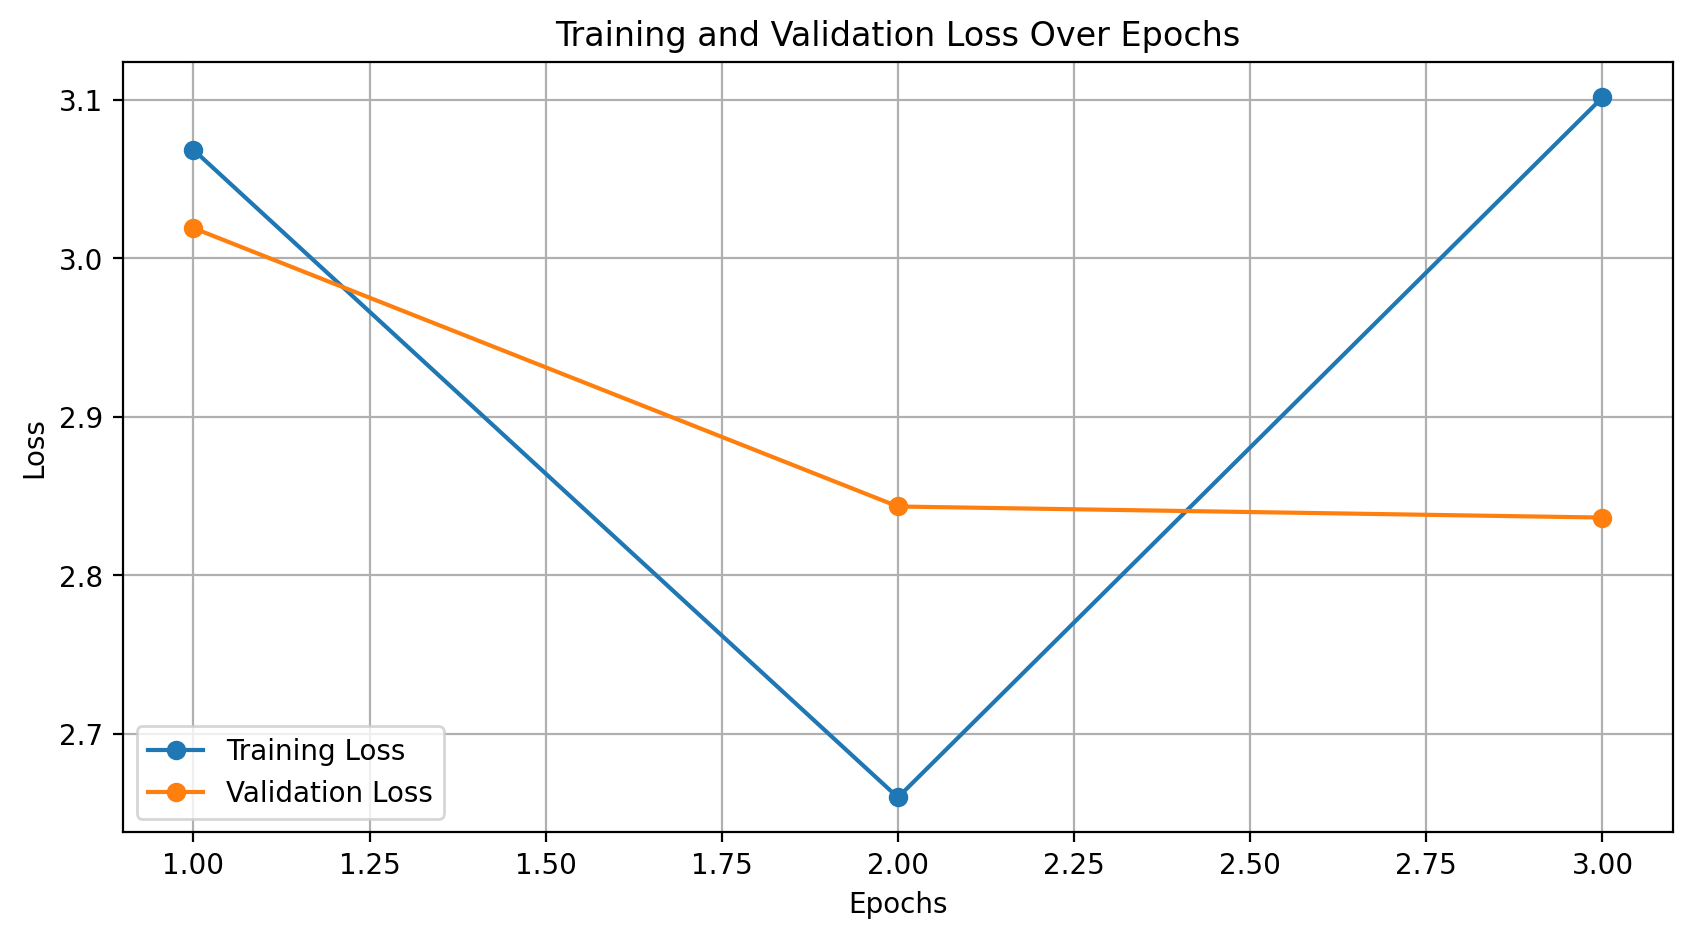

In [ ]:
import matplotlib.pyplot as plt

# Manually recorded training and validation loss values from the output
epochs = [1, 2, 3]
training_loss = [3.068600, 2.659800, 3.101600]
validation_loss = [3.019146, 2.843429, 2.836447]

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, training_loss, label="Training Loss", marker='o')
plt.plot(epochs, validation_loss, label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()



**Justification:** The code plots the training and validation loss over epochs to visualize model performance during fine-tuning. This helps in assessing the model's learning progress and identifying potential overfitting or underfitting issues.

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated MIDI pitch sequence: 1 52 43 55 73 63 44 65 49 59 74 58 48 79 61 47 34 77 76 72 54 80 84 35 33 45 36 37 60 57 39 29 78 53 64 69 87 50 94 31 91 28 38 71 88 27 92 42 99 30 68 102 98 41 32 51 81 93 85 97 96 75 89 100 62 67 103 83 56 82 90 101 95 46 40 66 25 26 16 70 14 20 17 19 18 21 24 12 0 22 2 3 6 4 9 15 5 86 1 8


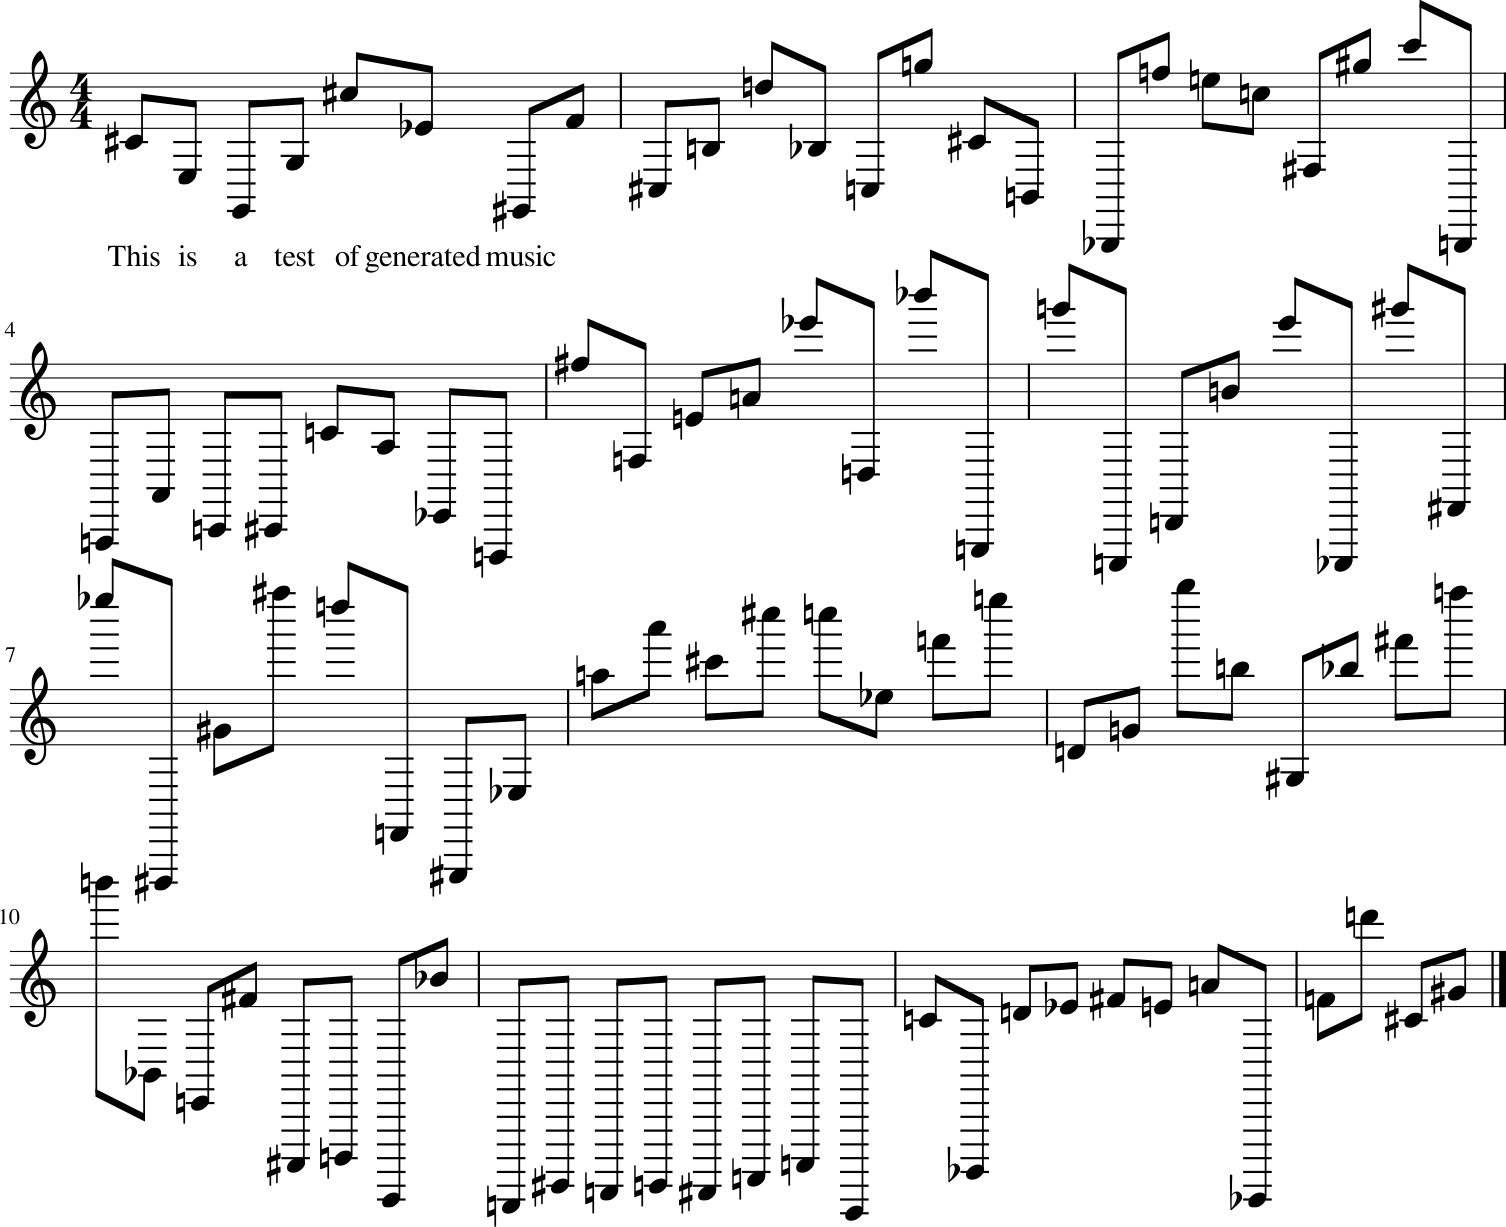

Saved MIDI file to generated_music21.mid


In [ ]:
# Music generation
input_prompt = "1"  # Example input prompt
input_ids = tokenizer(input_prompt, return_tensors='pt').input_ids
attention_mask = tokenizer(input_prompt, return_tensors='pt').attention_mask

output = model.generate(
    input_ids,
    attention_mask=attention_mask,
    max_length=100,
    num_return_sequences=1,
    do_sample=True,
    temperature=1.2,
    top_k=50,
    top_p=0.95,
    repetition_penalty=2.0
)

output_text = tokenizer.decode(output[0], skip_special_tokens=True)
print("Generated MIDI pitch sequence:", output_text)


# Convert the generated sequence to a music21 score
def convert_sequence_to_score(sequence, note_duration=0.5):
    notes = sequence.split()
    score = music21.stream.Score()
    part = music21.stream.Part()

    for pitch in notes:
        note_pitch = int(pitch)
        note = music21.note.Note(note_pitch)
        note.quarterLength = note_duration
        part.append(note)

    score.append(part)
    return score

score = convert_sequence_to_score(output_text)

# Optionally, add chords to the score
def add_chords_to_score(score):
    chords = [
        music21.chord.Chord(['C4', 'E4', 'G4']),
        music21.chord.Chord(['F4', 'A4', 'C5']),
        music21.chord.Chord(['G4', 'B4', 'D5']),
        music21.chord.Chord(['C4', 'E4', 'G4'])
    ]

    for chord in chords:
        chord.quarterLength = 2  # Each chord lasts for two beats
        score.insert(chord.offset, chord)

    return score

# Optionally, add lyrics to the score
def add_lyrics_to_score(score, lyrics):
    part = score.parts[0]
    for i, note in enumerate(part.notes):
        if i < len(lyrics):
            note.lyric = lyrics[i]
    return score

# Add chords and lyrics if needed
score = add_chords_to_score(score)
lyrics = "This is a test of generated music".split()
score = add_lyrics_to_score(score, lyrics)


# Install MuseScore and show the score
subprocess.call(['apt-get', 'update'])
subprocess.call(['apt-get', 'install', '-y', 'musescore3'])

def show_and_save_score(score, output_midi_file='generated_music21.mid'):
    score.show()  # This will open MuseScore or an equivalent viewer
    mf = music21.midi.translate.music21ObjectToMidiFile(score)
    mf.open(output_midi_file, 'wb')
    mf.write()
    mf.close()
    print(f"Saved MIDI file to {output_midi_file}")

# Show and save the score as a MIDI file
show_and_save_score(score, 'generated_music21.mid')


# Play the MIDI file
score = music21.converter.parse("generated_music21.mid")
score.show('midi')

**Justification:** The code generates a music sequence using GPT-2, converts it to a music score, optionally adds chords and lyrics, saves it as a MIDI file, and plays it back. It leverages music21 for score creation and MuseScore for visualization, providing a complete pipeline from generation to playback.